In [12]:
import datetime
import os
import warnings

from database import data_utils, shape_utils

import geopandas
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import pickle
import seaborn as sns

import importlib
importlib.reload(data_utils)

<module 'database.data_utils' from '/Users/zack/Desktop/valle/src/database/data_utils.py'>

In [2]:
overwrite=True
run_name="3_mo_cross_val"
network_name="kcm"
gtfs_folder="../data/kcm_gtfs/2021_10_14/"
raw_data_folder="../data/kcm_all/"
timezone="America/Los_Angeles"
given_names=['tripid','file','locationtime','lat','lon','vehicleid']
train_dates=data_utils.get_date_list("2022_01_01", 31)
test_dates=data_utils.get_date_list("2022_02_01", 7)
n_folds=10

In [3]:
### Load data from raw bus data files
print("="*30)
print(f"Combining raw bus data files...")
# Get traces from all data
train_data, train_fail_dates = data_utils.combine_pkl_data(raw_data_folder, train_dates, given_names)
test_data, test_fail_dates = data_utils.combine_pkl_data(raw_data_folder, test_dates, given_names)
print(f"Lost dates train: {train_fail_dates}, {len(train_data)} samples kept.")
print(f"Lost dates test: {test_fail_dates}, {len(test_data)} samples kept.")

# Load the GTFS
print(f"Loading and merging GTFS files from '{gtfs_folder}'...")
gtfs_data = data_utils.merge_gtfs_files(gtfs_folder)

# Calculate distance between points in each trajectory, do some filtering on speed, n_points
print(f"Calculating trace trajectories, filtering on speed and number of trajectory points...")
train_traces = data_utils.calculate_trace_df(train_data, timezone)
test_traces = data_utils.calculate_trace_df(test_data, timezone)
print(f"Cumulative {np.round(len(train_traces) / len(train_data) * 100, 1)}% of train data retained.")
print(f"Cumulative {np.round(len(test_traces) / len(test_data) * 100, 1)}% of test data retained.")

# Match trajectories to timetables and do filtering on stop distance, availability
print(f"Matching traces to GTFS timetables, filtering on nearest scheduled stop distance, schedule availability...")
train_traces = data_utils.clean_trace_df_w_timetables(train_traces, gtfs_data)
test_traces = data_utils.clean_trace_df_w_timetables(test_traces, gtfs_data)
print(f"Cumulative {np.round(len(train_traces) / len(train_data) * 100, 1)}% of train data retained. Saving {len(train_traces)} samples.")
print(f"Cumulative {np.round(len(test_traces) / len(test_data) * 100, 1)}% of test data retained. Saving {len(test_traces)} samples.")

# Get unique vehicle ids
(train_traces, test_traces), n_unique_veh = data_utils.remap_vehicle_ids([train_traces, test_traces])
print(f"Found {n_unique_veh} unique vehicle IDs in this data.")

Combining raw bus data files...
Lost dates train: ['2022_01_01.pkl', '2022_01_03.pkl', '2022_01_05.pkl', '2022_01_06.pkl', '2022_01_07.pkl', '2022_01_11.pkl', '2022_01_13.pkl'], 436755 samples kept.
Lost dates test: [], 173566 samples kept.
Loading and merging GTFS files from '../data/kcm_gtfs/2021_10_14/'...
Calculating trace trajectories, filtering on speed and number of trajectory points...
Cumulative 46.6% of train data retained.
Cumulative 51.8% of test data retained.
Matching traces to GTFS timetables, filtering on nearest scheduled stop distance, schedule availability...
Cumulative 44.4% of train data retained. Saving 193720 samples.
Cumulative 49.2% of test data retained. Saving 85438 samples.
Found 1132 unique vehicle IDs in this data.


In [4]:
# Histogram of bus travel times in schedule
gtfs_data['arrival_s_prev'] = gtfs_data.groupby('trip_id').shift()[['arrival_s']]
gtfs_data_times = gtfs_data[['arrival_s','arrival_s_prev']].dropna()
gtfs_data_times['tt'] = gtfs_data_times['arrival_s'] - gtfs_data_times['arrival_s_prev']
gtfs_data_times

,arrival_s,arrival_s_prev,tt
226,24768,24720.0,48.0
298,24793,24768.0,25.0
370,24839,24793.0,46.0
384,24894,24839.0,55.0
398,24960,24894.0,66.0
...,...,...,...
949108,26040,25560.0,480.0
376975,27720,26040.0,1680.0
846742,28080,27720.0,360.0
534365,28920,28080.0,840.0


/Users/zack/miniconda3/envs/valle_m1/lib/python3.10/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)
/Users/zack/miniconda3/envs/valle_m1/lib/python3.10/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


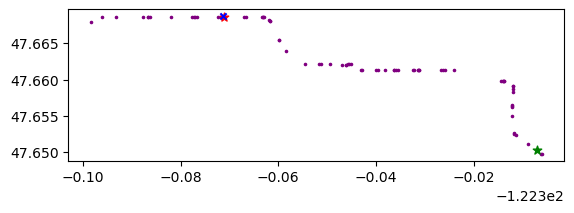

In [5]:
# Showing a bus trip with stop and start locations
fig, axes = plt.subplots(1,1)
shape_utils.plot_gtfsrt_trip(ax=axes, trace_df=train_traces[train_traces['trip_id']=="540512329"])

In [13]:
kcm_dates, kcm_data_summaries = data_utils.full_dataset_summary("../data/kcm_all", ['tripid','file','locationtime','lat','lon','vehicleid'], "America/Los_Angeles")

In [14]:
atb_dates, atb_data_summaries = data_utils.full_dataset_summary("../data/atb_all", ['datedvehiclejourney','file','locationtime','lat','lon','vehicle'], "Europe/Oslo")

This should not print unless processing AtB data
This should not print unless processing AtB data
This should not print unless processing AtB data
This should not print unless processing AtB data
This should not print unless processing AtB data
This should not print unless processing AtB data
This should not print unless processing AtB data
This should not print unless processing AtB data
This should not print unless processing AtB data
This should not print unless processing AtB data
This should not print unless processing AtB data
This should not print unless processing AtB data
This should not print unless processing AtB data
This should not print unless processing AtB data
This should not print unless processing AtB data
This should not print unless processing AtB data
This should not print unless processing AtB data
This should not print unless processing AtB data
This should not print unless processing AtB data
This should not print unless processing AtB data
This should not prin

In [15]:
nwy_dates, nwy_data_summaries = data_utils.full_dataset_summary("../data/nwy_all", ['datedvehiclejourney','file','locationtime','lat','lon','vehicle'], "Europe/Oslo")

This should not print unless processing AtB data
This should not print unless processing AtB data
This should not print unless processing AtB data
This should not print unless processing AtB data
This should not print unless processing AtB data
This should not print unless processing AtB data
This should not print unless processing AtB data
This should not print unless processing AtB data
This should not print unless processing AtB data
This should not print unless processing AtB data
This should not print unless processing AtB data
This should not print unless processing AtB data
This should not print unless processing AtB data
This should not print unless processing AtB data
This should not print unless processing AtB data
This should not print unless processing AtB data
This should not print unless processing AtB data
This should not print unless processing AtB data
This should not print unless processing AtB data
This should not print unless processing AtB data
This should not prin

In [16]:
kcm_stats = pd.DataFrame({
    "Date": kcm_dates,
    "Observations": [x['n_points'] for x in kcm_data_summaries],
    "Trajectories": [x['n_trajs'] for x in kcm_data_summaries],
    "Unique Trips": [x['nunq_trips'] for x in kcm_data_summaries],
    "Unique Vehicles": [x['nunq_vehs'] for x in kcm_data_summaries]
})
kcm_stats["City"] = "Seattle"
atb_stats = pd.DataFrame({
    "Date": atb_dates,
    "Observations": [x['n_points'] for x in atb_data_summaries],
    "Trajectories": [x['n_trajs'] for x in atb_data_summaries],
    "Unique Trips": [x['nunq_trips'] for x in atb_data_summaries],
    "Unique Vehicles": [x['nunq_vehs'] for x in atb_data_summaries]
})
atb_stats["City"] = "Trondheim"
nwy_stats = pd.DataFrame({
    "Date": nwy_dates,
    "Observations": [x['n_points'] for x in nwy_data_summaries],
    "Trajectories": [x['n_trajs'] for x in nwy_data_summaries],
    "Unique Trips": [x['nunq_trips'] for x in nwy_data_summaries],
    "Unique Vehicles": [x['nunq_vehs'] for x in nwy_data_summaries]
})
nwy_stats["City"] = "Norway"
plot_data = pd.concat([kcm_stats, atb_stats, nwy_stats], axis=0)
# plot_data = pd.melt(plot_data, ["Date","City"])

In [17]:
with warnings.catch_warnings():
    # nanmean returns a warning if the array is all nan values
    warnings.simplefilter("ignore", category=RuntimeWarning)
    kcm_hourly_stats = pd.DataFrame({
        "Hour": np.arange(24, dtype="int32"),
        "Hourly Points": list(np.mean(np.array([x['hourly_points'] for x in kcm_data_summaries]), axis=0, dtype="int32")),
        "Hourly Mean Speed (m/s)": list(np.nanmean(np.array([x['hourly_mean_speeds'] for x in kcm_data_summaries]), axis=0, dtype="float32")),
        "Hourly SD Speed (m/s)": list(np.nanmean(np.array([x['hourly_sd_speeds'] for x in kcm_data_summaries]), axis=0, dtype="float32"))
    })
    kcm_hourly_stats["City"] = "Seattle"
    atb_hourly_stats = pd.DataFrame({
        "Hour": np.arange(24, dtype="int32"),
        "Hourly Points": list(np.mean(np.array([x['hourly_points'] for x in atb_data_summaries]), axis=0, dtype="int32")),
        "Hourly Mean Speed (m/s)": list(np.nanmean(np.array([x['hourly_mean_speeds'] for x in atb_data_summaries]), axis=0, dtype="float32")),
        "Hourly SD Speed (m/s)": list(np.nanmean(np.array([x['hourly_sd_speeds'] for x in atb_data_summaries]), axis=0, dtype="float32"))
    })
    atb_hourly_stats["City"] = "Trondheim"
    nwy_hourly_stats = pd.DataFrame({
        "Hour": np.arange(24, dtype="int32"),
        "Hourly Points": list(np.mean(np.array([x['hourly_points'] for x in nwy_data_summaries]), axis=0, dtype="int32")),
        "Hourly Mean Speed (m/s)": list(np.nanmean(np.array([x['hourly_mean_speeds'] for x in nwy_data_summaries]), axis=0, dtype="float32")),
        "Hourly SD Speed (m/s)": list(np.nanmean(np.array([x['hourly_sd_speeds'] for x in nwy_data_summaries]), axis=0, dtype="float32"))
    })
    nwy_hourly_stats["City"] = "Norway"
plot_data_hourly = pd.concat([kcm_hourly_stats, atb_hourly_stats, nwy_hourly_stats], axis=0).fillna(np.inf)

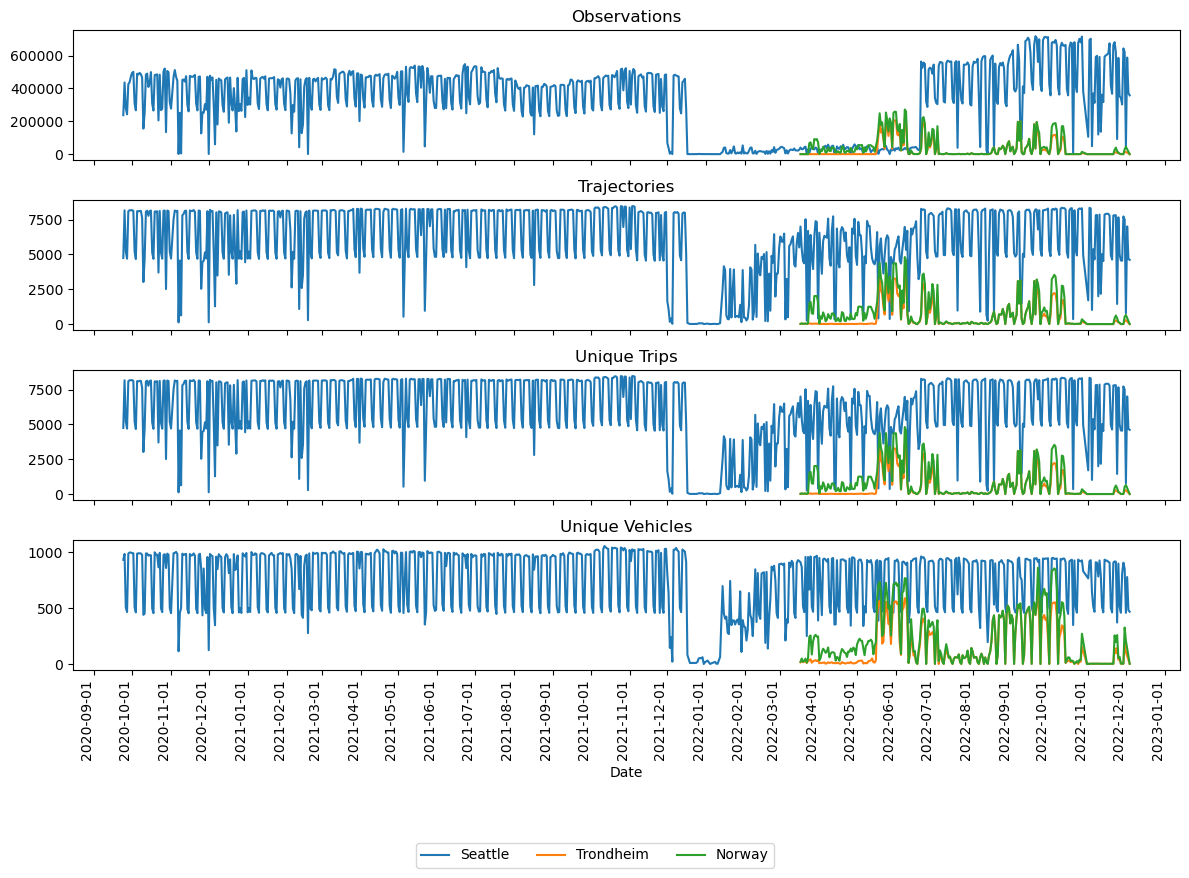

In [18]:
fig, axes = plt.subplots(4,1)
fig.set_figheight(8)
fig.set_figwidth(12)

fig.autofmt_xdate(rotation=90)
sns.lineplot(plot_data, x="Date", y="Observations", hue="City", ax=axes[0])
sns.lineplot(plot_data, x="Date", y="Trajectories", hue="City", ax=axes[1])
sns.lineplot(plot_data, x="Date", y="Unique Trips", hue="City", ax=axes[2])
sns.lineplot(plot_data, x="Date", y="Unique Vehicles", hue="City", ax=axes[3])
axes[0].set_title("Observations")
axes[1].set_title("Trajectories")
axes[2].set_title("Unique Trips")
axes[3].set_title("Unique Vehicles")
for ax in axes:
    ax.legend().set_visible(False)
    ax.set_ylabel(None)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
plt.figlegend(lines_labels[0][0], lines_labels[0][1], bbox_to_anchor=(0.5, -0.1), loc='lower center', ncol=5, labelspacing=0.)
fig.tight_layout()
plt.savefig("../plots/timeline_of_collection.png", dpi=1800, bbox_inches='tight')

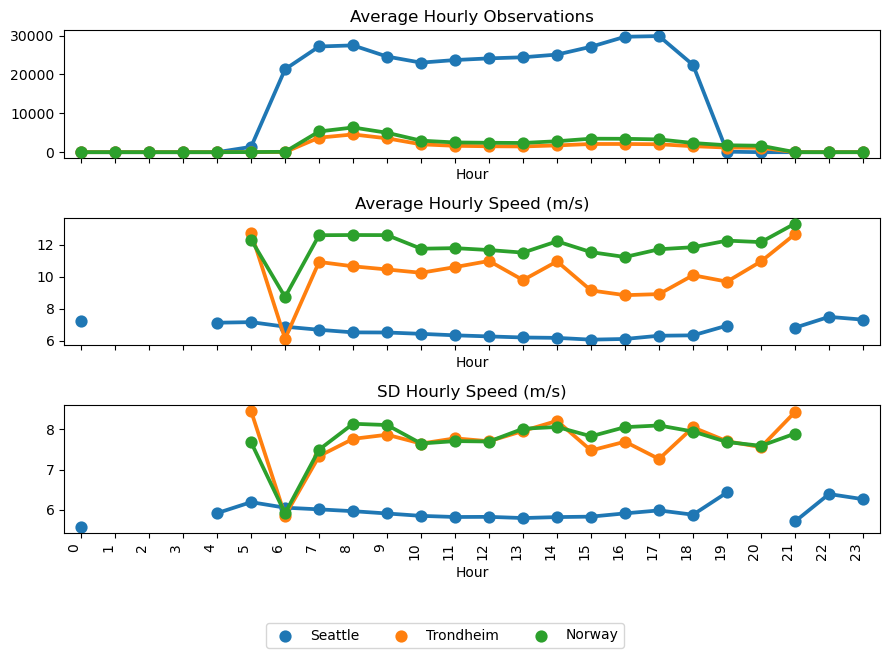

In [19]:
fig, axes = plt.subplots(3,1)
fig.set_figheight(6)
fig.set_figwidth(9)

fig.autofmt_xdate(rotation=90)
sns.pointplot(plot_data_hourly, x="Hour", y="Hourly Points", hue="City", ax=axes[0])
sns.pointplot(plot_data_hourly, x="Hour", y="Hourly Mean Speed (m/s)", hue="City", ax=axes[1], errorbar=lambda x: (x.min(), x.max()))
sns.pointplot(plot_data_hourly, x="Hour", y="Hourly SD Speed (m/s)", hue="City", ax=axes[2], errorbar=lambda x: (x.min(), x.max()))
axes[0].set_title("Average Hourly Observations")
axes[1].set_title("Average Hourly Speed (m/s)")
axes[2].set_title("SD Hourly Speed (m/s)")
for ax in axes:
    ax.legend().set_visible(False)
    ax.set_ylabel(None)
    ax.set_xticks(np.arange(24))
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
plt.figlegend(lines_labels[0][0], lines_labels[0][1], bbox_to_anchor=(0.5, -0.1), loc='lower center', ncol=5, labelspacing=0.)
fig.tight_layout()
plt.savefig("../plots/timeline_hourly_collection.png", dpi=1800, bbox_inches='tight')

In [20]:
# How many days are there
print(f"Number of observation days: KCM {len(kcm_dates)}, ATB {len(atb_dates)}, NWY {len(nwy_dates)}")
# How many observations are there total
print(f"Number of observed GPS points: KCM {np.sum(kcm_stats['Observations'])}, ATB {np.sum(atb_stats['Observations'])}, , NWY {np.sum(nwy_stats['Observations'])}")
# How many observations are there per day on average
kcm_per_day = int(np.sum(kcm_stats['Observations']) / len(kcm_dates))
atb_per_day = int(np.sum(atb_stats['Observations']) / len(atb_dates))
nwy_per_day = int(np.sum(nwy_stats['Observations']) / len(nwy_dates))
print(f"Number of points per day: KCM {kcm_per_day}, ATB {atb_per_day}, NWY {nwy_per_day}")
# How many points per trajectory are there on average
kcm_points_per_trip = int(np.sum(kcm_stats['Observations']) / np.sum(kcm_stats['Trajectories']))
atb_points_per_trip = int(np.sum(atb_stats['Observations']) / np.sum(atb_stats['Trajectories']))
nwy_points_per_trip = int(np.sum(nwy_stats['Observations']) / np.sum(nwy_stats['Trajectories']))
print(f"Average points per trajectory: KCM {kcm_points_per_trip}, ATB {atb_points_per_trip}, NWY {nwy_points_per_trip}")

Number of observation days: KCM 784, ATB 250, NWY 250
Number of observed GPS points: KCM 260023761, ATB 7610935, , NWY 11478600
Number of points per day: KCM 331662, ATB 30443, NWY 45914
Average points per trajectory: KCM 54, ATB 56, NWY 53


In [21]:
# Read in network shape data
with open('../data/processed_networks/kcm_segments.pkl', 'rb') as f:
    kcm_segments = pickle.load(f)
    kcm_segments = kcm_segments.to_crs('EPSG:32148')
with open('../data/processed_networks/atb_segments.pkl', 'rb') as f:
    atb_segments = pickle.load(f)
    atb_segments = atb_segments.to_crs('EPSG:25833')

In [22]:
# How much lane mileage is covered
kcm_mileage = int(np.sum(kcm_segments.length) / 1000)
atb_mileage = int(np.sum(atb_segments.length) / 1000)
print(f"Number of roadway kilometers: KCM {kcm_mileage}, ATB {atb_mileage}")
# How much area is covered
kcm_bounds = kcm_segments.bounds
kcm_area = int(((max(kcm_bounds.maxx) - min(kcm_bounds.minx)) / 1000) * ((max(kcm_bounds.maxy) - min(kcm_bounds.miny)) / 1000))
atb_bounds = atb_segments.bounds
atb_area = int(((max(atb_bounds.maxx) - min(atb_bounds.minx)) / 1000) * ((max(atb_bounds.maxy) - min(atb_bounds.miny)) / 1000))
print(f"Total network area: KCM {kcm_area}, ATB {atb_area}")

Number of roadway kilometers: KCM 3379, ATB 4679
Total network area: KCM 4175, ATB 83683
